# Noisy and Repellant

Your task with this assignment is to parallelize a serial application using OpenMP, and to use profiling tools to assess different approaches to that parallelization.

**Due Thursday, September 19, before class**

This assignment is intended for the CPU-only nodes, where we can get a lot of CPU thread concurrency.  However, once you have completed the main part of the assignment, if you intend to do the bonus work using the GPUs, complete that portion on a node with a P100 GPU.

In [1]:
module use $CSE6230_DIR/modulefiles
module load cse6230/core

|                                                                         |
|       A note about python/3.6:                                          |
|       PACE is lacking the staff to install all of the python 3          |
|       modules, but we do maintain an anaconda distribution for          |
|       both python 2 and python 3. As conda significantly reduces        |
|       the overhead with package management, we would much prefer        |
|       to maintain python 3 through anaconda.                            |
|                                                                         |
|       All pace installed modules are visible via the module avail       |
|       command.                                                          |
|                                                                         |


In [1]:
module list

Currently Loaded Modulefiles:
  1) curl/7.42.1
  2) git/2.13.4
  3) python/3.6
  4) /nv/coc-ice/tisaac3/opt/pace-ice/modulefiles/jupyter/1.0
  5) intel/16.0
  6) cuda/8.0.44
  7) /nv/coc-ice/tisaac3/opt/pace-ice/modulefiles/hpctoolkit/2018.18
  8) impi/5.1.1.109
  9) cse6230/core(default)


Last time, we modelled non-interacting particles as an example of a streaming kernel.  This time, we are going to advance things a bit and have particles that interact with each other and with the "media" in which they move.

Both gravitational and electrical forces are often modeled as deriving from a simple *potential*: the potential between two particles $p_1$ and $p_2$ is a function of their distance:

$$ \varphi(p_1, p_2) = k \frac{e_1 e_2}{\|r_1 - r_2\|}, $$

Where $r_1$ and $r_2$ are their positions, $e_1$ and $e_2$ are their charges, and $k$ is a scaling factor.  In this assignment we will assume $e_i = 1$ for all particles.  The force acting on $p_1$ due to the potential is the negative of its gradient with respect to $r_2$,

$$ F(p_1, p_2) = -\nabla_{r_1} \varphi(p_1, p_2). $$

The whole equal-and-opposite thing in physics implies that a force with the same magnitude and opposite direction acts on $p_2$: $F(p_2, p_1) = - F(p_1, p_2)$.  In this toy problem, all particle masses are equal to 1, so the acceleration due to a force is equivalent to the force.  The *total acceleration* experienced by a particle is the sum of the forces from all other particles:

$$ \partial v_i / \partial t = \sum_{j \neq i} F(p_i, p_j).$$

Now we see what makes this different from the streaming kernel we studied last week: to update one particle involves contributions from all other particles, $O(N_p^2)$ interactions!

Particles that are affected only by potentials is a good model for particles moving in a vaccuum, but sometimes we want to model particles moving in a medium, where the collide frequently and randomly with other particles.  This type of motion is called [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion). We'll skip a bunch of statistical physics and jump to the conclusion: whereas numerical time-stepping of a classical force
often takes the form of an update like

$$ x_{i,t+1} = x_{i,t} + f \Delta{t}, $$

Brownian motion looks like,

$$ x_{i,t+1} = x_{i,t} + \sqrt{2 d \Delta{t}}z, $$

where $z$ is a realization of a random variable.

If we have charged particles moving in a medium, then both potential and noisy contributions affect the motion of the particle.  Our program for this assignment includes both!  That makes this program more complicated to model and to optimize: we cannot reduce the performance down to the behavior of one kernel, but must try to evaluate when each kernel is the bottleneck.

Before you start with the actual assignment, let me show you what all of this looks like.
We run the program with `make runcloud`, like last time, and many of the variables that define the behavior of the target are the same: `NP` is the number of particles, `DT` is the step size, and `NT` is the number of steps. `K` is the potential coefficient $k$: negative values cause particles to attract and positive values cause particles to repel.  `D` is the diffusion coefficient of Brownian motion.

We can make this example look most like the last assignment by turning off Brownian motion and choosing negative $k$:

In [15]:
OMP_PROC_BIND="spread" OMP_NUM_THREADS=4 make runcloud NP=512 DT=1.e-5 NT=400 D=0. K=-1.

make --silent clean
make --silent cloud
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
./cloud 512 400 1.e-5 -1. 0.
[./cloud] NUM_POINTS=512, NUM_STEPS=400, CHUNK_SIZE=400, DT=1e-05, K=-1, D=0
[./cloud] Hamiltonian, T = 0: -452612
[./cloud] Simulation walltime: 1.62407
[./cloud] Hamiltonian, T = 0.004: 972403, Relative Error: -3.14842
[./cloud] Average Distance Traveled: 0.0251215


You'll notice the output describes the "Hamiltonian" of the system.  This is like the total energy, and is theoretically conserved.  When I ran the above, it was conserved to 5 decimal places.  But these $n$-body systems are chaotic, and in particular they are unstable with particles that attract each other.  If we run the same program for just twice as long:

In [4]:
make runcloud NP=32 DT=1.e-5 NT=800 D=0. K=-1.

make --silent clean
make --silent cloud
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
./cloud 32 800 1.e-5 -1. 0.
[./cloud] NUM_POINTS=32, NUM_STEPS=800, CHUNK_SIZE=800, DT=1e-05, K=-1, D=0
[./cloud] Hamiltonian, T = 0: -1772.57
[./cloud] Simulation walltime: 0.0396902
[./cloud] Hamiltonian, T = 0.008: 3534.09, Relative Error: -2.99377
[./cloud] Average Distance Traveled: 0.00993427


For this assignment, I made a tool for us to visualize our simulations.  We can generate videos of our simulations, and we can embed them in this notebook.  We do this with the
`make vizcloud` target, which takes the same arguments as `make runcloud`, but also `CHUNK` (the number of time steps between frames of the video) and `VIZNAME`, the basename of the output video.  Like so:

make --silent clean
make --silent cloud
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
./cloud 8 800 1.e-3 -1. 0.0 10 attract | xvfb-run python3 cloud.py


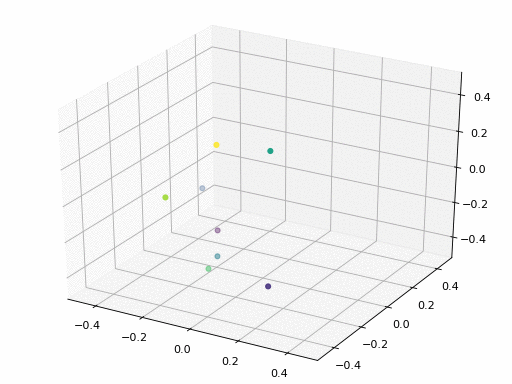

In [5]:
make vizcloud NP=8 DT=1.e-3 NT=800 D=0.0 K=-1. CHUNK=10 VIZNAME="attract"
display < attract.gif

You can see that the particles fling each other around, and with our fixed time step big errors occur when particles get close to each other.

You'll also notice that this problem occurs in a periodic domain, so particles can't get away from each other.  This ensures that they keep interacting, and is a common strategy to simulate an infinite, uniform distribution of particles.

If we instead model particles that repel each other, this behavior is a bit more stable:

In [ ]:
make vizcloud NP=8 DT=1.e-3 NT=800 D=0.0 K=1. CHUNK=10 VIZNAME="repel"
display < repel.gif

Finally, if we turn the potential interactions off, and turn the noisy interactions back on, we see browning motion:

make --silent clean
make --silent cloud
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
./cloud 8 800 1.e-3 0. 0.1 10 noisy | xvfb-run python3 cloud.py


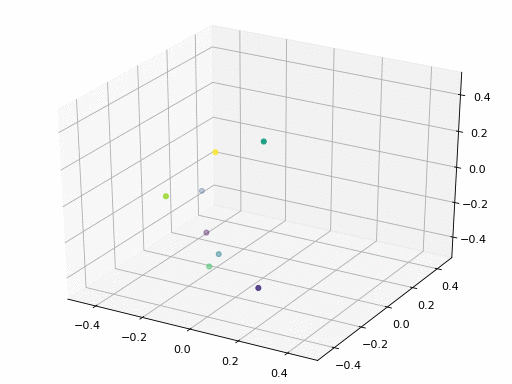

In [6]:
make vizcloud NP=8 DT=1.e-3 NT=800 D=0.1 K=0. CHUNK=10 VIZNAME="noisy"
display < noisy.gif

With Brownian motion, there is no "right" path for a particle to take, so any verification of the behavior has to be *statistical.*  In particular, one behavior of Brownian motion is that the distance a particle travels over time $\Delta{T}$ is on average $\sqrt{\Delta{T}}$.  We should be able to verify this: if we increase `NT` by a factor of 4, the average distance travelled should double.

In [ ]:
make runcloud NP=64 DT=1.e-3 NT=800 D=0.1 K=0.

In [ ]:
make runcloud NP=64 DT=1.e-3 NT=3200 D=0.1 K=0.

I know this is a long set up to the assignment, but our first project is going to keep building on this particle simulation, so I would like you to have a little understanding of what the parameters to the program mean.

For the remainder of this assignment, we'll keep the parameters `K=-1.`, `D=0.1`, and `DT=1.e-3` (which are the defaults in `Makefile`)

**Question 1 (5 pts)**: This program is currently a valid serial program.  Your first task is to convert it to a high-performing OpenMP program.  You will have to change

- The compiler flags (see the `OMPFLAGS` variable in `Makefile`)
- The runtime environment (You may either add new cells in this notebook that specify environment variables like `OMP_NUM_THREADS`, or you can add those in front of the targets, like `OMP_NUM_THREADS=5 make runcloud ...`)
- The code itself.  When modifying the code, you should show awareness of the issues that we discussed in class:
  - Scheduling: have you chosen a loop schedule that is balanced?  If your schedule is dynamic, is the additional overhead worth it?
  - Race conditions: how will you handle them?
  - Scoping: are you using the variables properly?

To modify the code, there are four operations that you will need to address.

- Initializing the variables, in `initialize.c`

In [7]:
pygmentize initialize.c

#include "cloud.h"

void
initialize_variables (int Np, double k, cse6230rand_t *rand, double *X0[3], double *X[3], double *U[3])
{
  size_t init_tag;

  init_tag = cse6230rand_get_tag (rand);
  for (int i = 0; i < Np; i+=4) { /* for every particle */
    double xval[3][4];
    double uval[3][4];

    for (int d = 0; d < 3; d++) { /* get four random doubles for each variable */
      cse6230rand_hash (rand, init_tag, i,     d, 0, &xval[d][0]);
      if (k) {
        cse6230rand_hash (rand, init_tag, i, 3 + d, 0, &uval[d][0]);
      }
      else {
        for (int j = 0; j < 4; j++) {
          uval[d][j] = 0.5;
        }
      }
    }

    if (i + 4 <= Np) {
      for (int j = 0; j < 4; j++) {
        for (int d = 0; d < 3; d++) { /* scale uniform [0,1) variables to [-1, 1) */
          X0[d][i + j] = X[d][i + j] = 2. * xval[d][j] - 1.;
          U[d][i + j] = 2. * uval[d][j] - 1.;
        }
      }
    }
    else {
      for (int j = 0; j < Np - i; j++) {
        for (int d = 0; d < 3;

- Compute the Hamiltonian, in `hamiltonian.c`

In [8]:
pygmentize hamiltonian.c

#include "cloud.h"

double
compute_hamiltonian (int Np, double k, const double *X[3], const double *U[3])
{
  double h = 0.;

  for (int i = 0; i < Np; i++) { /* for every particle */
    h += 0.5 * (U[0][i]*U[0][i] + U[1][i]*U[1][i] + U[2][i]*U[2][i]); /* kinetic energy */
    if (k) {
      for (int j = i + 1; j < Np; j++) { /* for every other particle */
        double hj = potential (k, X[0][i], X[1][i], X[2][i], X[0][j], X[1][j], X[2][j]);

        h += hj;
      }
    }
  }
  return h;
}


- Updating the positions due to the velocities and the noise, in `verlet_stream_and_noise.c`

In [9]:
pygmentize verlet_stream_and_noise.c

#include "cloud.h"
#include "verlet.h"

void
verlet_step_stream_and_noise (int Np, double dt_stream, double dt_noise,
                              cse6230rand_t *rand,
                              double *restrict X[3], const double *restrict U[3])
{
  if (dt_noise) {
    size_t tag;

    tag = cse6230rand_get_tag (rand);

    for (int i = 0; i < Np; i++) {
      double rval[4];

      cse6230rand_hash (rand, tag, i, 0, 0, rval);

      for (int d = 0; d < 3; d++) {
        X[d][i] += dt_stream * U[d][i] + dt_noise * (2. * rval[d] - 1.);
      }
    }
  }
  else {
    for (int i = 0; i < Np; i++) {
      for (int d = 0; d < 3; d++) {
        X[d][i] += dt_stream * U[d][i];
      }
    }
  }
}


- Finally, we must compute the force due to potential interactions.  There are two different approaches to how we could go about doing this:
  1. Compute each interaction $F(p_i,p_j)$ twice: once for $p_i$, and once for $p_j$, then update them separately.
  2. Compute each interaction $F(p_i,p_j)$ once, and update both particles using the equal-and-opposite rule.
  
In this assignment, we are going to do our best to optimize both approaches.

One is in `verlet_accelerate.c`, the other is in `verlet_accelerate2.c`

In [10]:
pygmentize verlet_accelerate.c

#include "verlet.h"
#include "cloud.h"

void
verlet_step_accelerate (int Np, double dt, const double *restrict X[3], double *restrict U[3])
{
  for (int i = 0; i < Np; i++) {
    double u[3] = {0.};

    for (int j = 0; j < Np; j++) {
      if (j != i) {
        double du[3];

        force (dt, X[0][i], X[1][i], X[2][i], X[0][j], X[1][j], X[2][j], du);

        for (int d = 0; d < 3; d++) {
          u[d] += du[d];
        }
      }
    }
    for (int d = 0; d < 3; d++) {
      U[d][i] += u[d];
    }
  }
}


In [11]:
pygmentize verlet_accelerate2.c # This gets used in runcloud2

#include "verlet.h"
#include "cloud.h"

void
verlet_step_accelerate (int Np, double dt, const double *restrict X[3], double *restrict U[3])
{
  for (int i = 0; i < Np; i++) {
    for (int j = i + 1; j < Np; j++) {
      double du[3];

      force (dt, X[0][i], X[1][i], X[2][i], X[0][j], X[1][j], X[2][j], du);

      for (int d = 0; d < 3; d++) {
        U[d][i] += du[d];
        U[d][j] -= du[d];
      }
    }
  }
}


Right now, there is a simple timer for the whole simulation.  Because this is a multikernel program, that may be insufficient to understand its behavior. 

We could modify the program to have timers for the individual kernels, or we could use profiling tools that lets us disentangle their contributions.

**Hint:**
- `initialize_variables` is structured like a streaming kernel: writing to each kernel independently.  The amount of work for each iteration should be the same.  Because of the "first-touch" policy of memory placement, we should use the same scheduling of this loop and subsequent streaming loops so that the memory for each particle is close to the CPU where the kernel will be executed (assuming that threads are bound to CPUs using `OMP_PROC_BIND`).  This suggests we should use a `static` schedule.  `schedule(static)` makes one big block of iterations for each thread, while `schedule(static,k)` assigns iterations to threads in a round-robin fasion in blocks of size `k`.  Should we prefer `schedule(static)` or `schedule(static,k)`?  `schedule(static)` will always have spatial locality; if we do `schedule(static,k)` for a small `k`, like `1` or `2`, then each thread will only read/write from a portion of a cache line in each iteration (because a cache line is 64 bytes = 4 doubles), and *false sharing* can occur.  For large values of `k`, `schedule(static,k)` should perform about the same as `schedule(static)`.

- `compute_hamiltionian` is computing a sum in `h`, which is a form of reduction, so a `reduction(+:sum)` is needed in the declaration of the parallel section. How should the double loop be scheduled?  The work is uneven, so `schedule(dynamic)` might plausibly be good, but it involves the overhead of dynamic scheduling.  We could make that overhead smaller by working dynamically in blocks, `schedule(dynamic,k)`.  As `k` gets bigger, the overhead will be smaller, but the dynamic scheduling granularity gets coarser, making load-balancing harder.  Another approach would be to use `schedule(static,k)` for a small value of `k`.  While the load will still be unbalanced, as for `schedule(static)`, it will be less so:

![static scheduling](./static.jpg)

- `verlet_step_stream_and_noise` is a streaming kernel, so the same scheduling should be used as `initialize_variables` as discussed above

- `verlet_step_accelerate` in `verlet_accelerate.c` a double loop with concurrent reads and exclusive writes, with each outer loop requiring the same amount of work, so the same loop schedule as for a streaming kernel will have good performance.

**Note:** when we were looking at streaming kernels in the STREAM benchmark, there was never a good reason to use `OMP_PROC_BIND=close` instead of `OMP_PROC_BIND=spread`: it was better to spread out the computation across the available memory channels.  In this double-loop version of `verlet_step_accelerate`, however, having all threads in the same NUMA domain will mean that no data travels between the two sockets that make up a node.  In my experiments, `verlet_step_accelerate` runs faster with 14 threads on one socket than with any number of threads on two sockets.

- `verlate_step_accelerate` in `verlet_accelerate2.c` has the same scheduling discussion as `compute_hamiltonian`, but instead of summing a single value in `h`, every thread tries to update every array location.  These conflicting updates must be protected to avoid race conditions, using either a `critical` or `atomic update`.  My experience has been that these memory synchronization requirements always make `verlet_accelerate2.c` slower than `verlet_accelerate.c`, even though half as many computations are performed. 

For this assignment, we will begin to use the tool [HPCToolkit](hpctoolkit.org) to profile our (parallel) applications.

The default class module should now load the various HPCToolkit commands.

In [12]:
which hpcrun

~/opt/pace-ice/hpctoolkit/bin/hpcrun


Take a look at the [overview](http://hpctoolkit.org/man/hpctoolkit.html) for how we profile an application.  There are a few distinct steps.

First, we run the code with `hpcrun` to gather statistics.  Depending on how we call it, `hpcrun` can simply keep track of the walltime of different rountines, can generate traces for all threads (`hpcrun -t`), and can also do hardware event counters (including ones we've already seen with `perf`.

In [13]:
hpcrun -L # Call this to get a great big list of hardware counters that are available.

Available Timer events
Name		Description
---------------------------------------------------------------------------
REALTIME	Real clock time used by the thread in microseconds.
		Based on the CLOCK_REALTIME timer with the SIGEV_THREAD_ID
		extension.  Includes time blocked in the kernel, but may
		not be available on all systems (eg, Blue Gene) and may
		break some syscalls that are sensitive to EINTR.

CPUTIME  	CPU clock time used by the thread in microseconds.  Based
		on the CLOCK_THREAD_CPUTIME_ID timer with the SIGEV_THREAD_ID
		extension.  May not be available on all systems (eg, Blue Gene).

WALLCLOCK 	CPU clock time used by the thread in microseconds.  Same
		as CPUTIME except on Blue Gene, where it is implemented
		by ITIMER_PROF.

Note: do not use multiple timer events in the same run.

Available memory leak detection events
Name		Description
---------------------------------------------------------------------------
MEMLEAK		The number of bytes allocated and freed per dyna

perf::CPU-CYCLES
                PERF_COUNT_HW_CPU_CYCLES

---------------------------------------------------------------------------
perf::PERF_COUNT_HW_INSTRUCTIONS
                PERF_COUNT_HW_INSTRUCTIONS

---------------------------------------------------------------------------
perf::INSTRUCTIONS
                PERF_COUNT_HW_INSTRUCTIONS

---------------------------------------------------------------------------
perf::PERF_COUNT_HW_CACHE_REFERENCES
                PERF_COUNT_HW_CACHE_REFERENCES

---------------------------------------------------------------------------
perf::CACHE-REFERENCES
                PERF_COUNT_HW_CACHE_REFERENCES

---------------------------------------------------------------------------
perf::PERF_COUNT_HW_CACHE_MISSES
                PERF_COUNT_HW_CACHE_MISSES

---------------------------------------------------------------------------
perf::CACHE-MISSES
                PERF_COUNT_HW_CACHE_MISSES

-------------------------------------------------

                Last level cache (*)

perf::PERF_COUNT_HW_CACHE_LL:READ
                read access (*)

perf::PERF_COUNT_HW_CACHE_LL:WRITE
                write access (*)

perf::PERF_COUNT_HW_CACHE_LL:PREFETCH
                prefetch access (*)

perf::PERF_COUNT_HW_CACHE_LL:ACCESS
                hit access (*)

perf::PERF_COUNT_HW_CACHE_LL:MISS
                miss access (*)

---------------------------------------------------------------------------
perf::LLC-LOADS Last level cache load accesses (*)

---------------------------------------------------------------------------
perf::LLC-LOAD-MISSES
                Last level cache load misses (*)

---------------------------------------------------------------------------
perf::LLC-STORES
                Last level cache store accesses (*)

---------------------------------------------------------------------------
perf::LLC-STORE-MISSES
                Last level cache store misses (*)

--------------------------------------------

                ext3_truncate_enter

perf::ext3:ext3_truncate_exit
                ext3_truncate_exit

perf::ext3:ext3_get_blocks_enter
                ext3_get_blocks_enter

perf::ext3:ext3_get_blocks_exit
                ext3_get_blocks_exit

perf::ext3:ext3_load_inode
                ext3_load_inode

---------------------------------------------------------------------------
perf::jbd       tracepoint (*)

perf::jbd:jbd_checkpoint
                jbd_checkpoint

perf::jbd:jbd_start_commit
                jbd_start_commit

perf::jbd:jbd_commit_locking
                jbd_commit_locking

perf::jbd:jbd_commit_flushing
                jbd_commit_flushing

perf::jbd:jbd_commit_logging
                jbd_commit_logging

perf::jbd:jbd_drop_transaction
                jbd_drop_transaction

perf::jbd:jbd_end_commit
                jbd_end_commit

perf::jbd:jbd_do_submit_data
                jbd_do_submit_data

perf::jbd:jbd_cleanup_journal_tail
                jbd_cleanup_journal_tail

perf


perf::kmem:mm_background_writeout
                mm_background_writeout

perf::kmem:mm_olddata_writeout
                mm_olddata_writeout

perf::kmem:mm_balancedirty_writeout
                mm_balancedirty_writeout

perf::kmem:mm_kswapd_ran
                mm_kswapd_ran

perf::kmem:mm_directreclaim_reclaimall
                mm_directreclaim_reclaimall

perf::kmem:mm_directreclaim_reclaimzone
                mm_directreclaim_reclaimzone

perf::kmem:mm_pagereclaim_shrinkzone
                mm_pagereclaim_shrinkzone

perf::kmem:mm_pagereclaim_shrinkactive
                mm_pagereclaim_shrinkactive

perf::kmem:mm_pagereclaim_shrinkinactive
                mm_pagereclaim_shrinkinactive

perf::kmem:mm_kernel_pagefault
                mm_kernel_pagefault

perf::kmem:mm_vmscan_kswapd_sleep
                mm_vmscan_kswapd_sleep

perf::kmem:mm_vmscan_kswapd_wake
                mm_vmscan_kswapd_wake

perf::kmem:mm_vmscan_wakeup_kswapd
                mm_vmscan_wakeup_kswapd

perf::kmem:


perf::syscalls:sys_enter_mq_open
                sys_enter_mq_open

perf::syscalls:sys_exit_mq_open
                sys_exit_mq_open

perf::syscalls:sys_enter_mq_unlink
                sys_enter_mq_unlink

perf::syscalls:sys_exit_mq_unlink
                sys_exit_mq_unlink

perf::syscalls:sys_enter_mq_timedsend
                sys_enter_mq_timedsend

perf::syscalls:sys_exit_mq_timedsend
                sys_exit_mq_timedsend

perf::syscalls:sys_enter_mq_timedreceive
                sys_enter_mq_timedreceive

perf::syscalls:sys_exit_mq_timedreceive
                sys_exit_mq_timedreceive

perf::syscalls:sys_enter_mq_notify
                sys_enter_mq_notify

perf::syscalls:sys_exit_mq_notify
                sys_exit_mq_notify

perf::syscalls:sys_enter_mq_getsetattr
                sys_enter_mq_getsetattr

perf::syscalls:sys_exit_mq_getsetattr
                sys_exit_mq_getsetattr

perf::syscalls:sys_enter_shmget
                sys_enter_shmget

perf::syscalls:sys_exit_shmget
      

                sys_enter_lsetxattr

perf::syscalls:sys_exit_lsetxattr
                sys_exit_lsetxattr

perf::syscalls:sys_enter_fsetxattr
                sys_enter_fsetxattr

perf::syscalls:sys_exit_fsetxattr
                sys_exit_fsetxattr

perf::syscalls:sys_enter_getxattr
                sys_enter_getxattr

perf::syscalls:sys_exit_getxattr
                sys_exit_getxattr

perf::syscalls:sys_enter_lgetxattr
                sys_enter_lgetxattr

perf::syscalls:sys_exit_lgetxattr
                sys_exit_lgetxattr

perf::syscalls:sys_enter_fgetxattr
                sys_enter_fgetxattr

perf::syscalls:sys_exit_fgetxattr
                sys_exit_fgetxattr

perf::syscalls:sys_enter_listxattr
                sys_enter_listxattr

perf::syscalls:sys_exit_listxattr
                sys_exit_listxattr

perf::syscalls:sys_enter_llistxattr
                sys_enter_llistxattr

perf::syscalls:sys_exit_llistxattr
                sys_exit_llistxattr

perf::syscalls:sys_enter_flistxattr
     


perf::syscalls:sys_exit_fchdir
                sys_exit_fchdir

perf::syscalls:sys_enter_chroot
                sys_enter_chroot

perf::syscalls:sys_exit_chroot
                sys_exit_chroot

perf::syscalls:sys_enter_fchmod
                sys_enter_fchmod

perf::syscalls:sys_exit_fchmod
                sys_exit_fchmod

perf::syscalls:sys_enter_fchmodat
                sys_enter_fchmodat

perf::syscalls:sys_exit_fchmodat
                sys_exit_fchmodat

perf::syscalls:sys_enter_chmod
                sys_enter_chmod

perf::syscalls:sys_exit_chmod
                sys_exit_chmod

perf::syscalls:sys_enter_fchownat
                sys_enter_fchownat

perf::syscalls:sys_exit_fchownat
                sys_exit_fchownat

perf::syscalls:sys_enter_chown
                sys_enter_chown

perf::syscalls:sys_exit_chown
                sys_exit_chown

perf::syscalls:sys_enter_lchown
                sys_enter_lchown

perf::syscalls:sys_exit_lchown
                sys_exit_lchown

perf::syscalls:sy


perf::syscalls:sys_enter_getpriority
                sys_enter_getpriority

perf::syscalls:sys_exit_getpriority
                sys_exit_getpriority

perf::syscalls:sys_enter_reboot
                sys_enter_reboot

perf::syscalls:sys_exit_reboot
                sys_exit_reboot

perf::syscalls:sys_enter_setregid
                sys_enter_setregid

perf::syscalls:sys_exit_setregid
                sys_exit_setregid

perf::syscalls:sys_enter_setgid
                sys_enter_setgid

perf::syscalls:sys_exit_setgid
                sys_exit_setgid

perf::syscalls:sys_enter_setreuid
                sys_enter_setreuid

perf::syscalls:sys_exit_setreuid
                sys_exit_setreuid

perf::syscalls:sys_enter_setuid
                sys_enter_setuid

perf::syscalls:sys_exit_setuid
                sys_exit_setuid

perf::syscalls:sys_enter_setresuid
                sys_enter_setresuid

perf::syscalls:sys_exit_setresuid
                sys_exit_setresuid

perf::syscalls:sys_enter_getresuid
      


perf::syscalls:sys_enter_wait4
                sys_enter_wait4

perf::syscalls:sys_exit_wait4
                sys_exit_wait4

perf::syscalls:sys_enter_syslog
                sys_enter_syslog

perf::syscalls:sys_exit_syslog
                sys_exit_syslog

perf::syscalls:sys_enter_personality
                sys_enter_personality

perf::syscalls:sys_exit_personality
                sys_exit_personality

perf::syscalls:sys_enter_set_tid_address
                sys_enter_set_tid_address

perf::syscalls:sys_exit_set_tid_address
                sys_exit_set_tid_address

perf::syscalls:sys_enter_unshare
                sys_enter_unshare

perf::syscalls:sys_exit_unshare
                sys_exit_unshare

perf::syscalls:sys_enter_sched_setscheduler
                sys_enter_sched_setscheduler

perf::syscalls:sys_exit_sched_setscheduler
                sys_exit_sched_setscheduler

perf::syscalls:sys_enter_sched_setparam
                sys_enter_sched_setparam

perf::syscalls:sys_exit_sched_set

                counter-mask in range [0-255] (*)

bdw_ep::BRANCH_INSTRUCTIONS_RETIRED:t
                measure any thread (*)

bdw_ep::BRANCH_INSTRUCTIONS_RETIRED:intx
                monitor only inside transactional memory region

bdw_ep::BRANCH_INSTRUCTIONS_RETIRED:intxcp
                do not count occurrences inside aborted transactional memory
                region

---------------------------------------------------------------------------
bdw_ep::MISPREDICTED_BRANCH_RETIRED
                Count mispredicted branch instructions at retirement.
                Specifically, this event counts at retirement of the last
                micro-op of a branch instruction in the architectural path of the
                execution and experienced misprediction in the branch prediction
                hardware

bdw_ep::MISPREDICTED_BRANCH_RETIRED:k
                monitor at priv level 0

bdw_ep::MISPREDICTED_BRANCH_RETIRED:u
                monitor at priv level 1, 2, 3

bdw_ep::MISP


bdw_ep::BR_MISP_EXEC:ALL_BRANCHES
                Speculative and retired mispredicted macro conditional branches

bdw_ep::BR_MISP_EXEC:TAKEN_INDIRECT_NEAR_CALL
                Taken speculative and retired mispredicted indirect calls

bdw_ep::BR_MISP_EXEC:TAKEN_RETURN_NEAR
                Taken speculative and retired mispredicted direct returns

bdw_ep::BR_MISP_EXEC:k
                monitor at priv level 0

bdw_ep::BR_MISP_EXEC:u
                monitor at priv level 1, 2, 3

bdw_ep::BR_MISP_EXEC:e
                edge level (may require counter-mask >= 1) (*)

bdw_ep::BR_MISP_EXEC:i
                invert

bdw_ep::BR_MISP_EXEC:c
                counter-mask in range [0-255] (*)

bdw_ep::BR_MISP_EXEC:t
                measure any thread (*)

bdw_ep::BR_MISP_EXEC:intx
                monitor only inside transactional memory region

bdw_ep::BR_MISP_EXEC:intxcp
                do not count occurrences inside aborted transactional memory
                region

------------------------

                Misses in all TLB levels causes a page walk that completes (4K)

bdw_ep::DTLB_LOAD_MISSES:WALK_COMPLETED_2M_4M
                Misses in all TLB levels causes a page walk of 2MB/4MB page sizes
                that completes

bdw_ep::DTLB_LOAD_MISSES:WALK_COMPLETED_1G
                Misses in all TLB levels causes a page walk of 1GB page sizes
                that completes

bdw_ep::DTLB_LOAD_MISSES:WALK_COMPLETED
                Misses in all TLB levels causes a page walk of any page size that
                completes

bdw_ep::DTLB_LOAD_MISSES:WALK_DURATION
                Cycles when PMH is busy with page walks

bdw_ep::DTLB_LOAD_MISSES:STLB_HIT_4K
                Misses that miss the DTLB and hit the STLB (4KB)

bdw_ep::DTLB_LOAD_MISSES:STLB_HIT_2M
                Misses that miss the DTLB and hit the STLB (2MB)

bdw_ep::DTLB_LOAD_MISSES:STLB_HIT
                Number of cache load STLB hits. No page walk

bdw_ep::DTLB_LOAD_MISSES:k
                monitor at priv 


bdw_ep::IDQ:DSB_UOPS
                Number of uops delivered to Instruction Decode Queue (IDQ) from
                Decode Stream Buffer (DSB) path

bdw_ep::IDQ:MS_DSB_UOPS
                Uops initiated by Decode Stream Buffer (DSB) that are being
                delivered to Instruction Decode Queue (IDQ) while Microcode
                Sequencer (MS) is busy

bdw_ep::IDQ:MS_MITE_UOPS
                Uops initiated by MITE and delivered to Instruction Decode Queue
                (IDQ) while Microcode Sequencer (MS) is busy

bdw_ep::IDQ:MS_UOPS
                Number of Uops were delivered into Instruction Decode Queue (IDQ)
                from MS, initiated by Decode Stream Buffer (DSB) or MITE

bdw_ep::IDQ:MS_UOPS_CYCLES
                Number of cycles that Uops were delivered into Instruction Decode
                Queue (IDQ) when MS_Busy, initiated by Decode Stream Buffer (DSB)
                or MITE

bdw_ep::IDQ:MS_SWITCHES
                Number of cycles that Uops were d


bdw_ep::ITLB:u  monitor at priv level 1, 2, 3

bdw_ep::ITLB:e  edge level (may require counter-mask >= 1) (*)

bdw_ep::ITLB:i  invert

bdw_ep::ITLB:c  counter-mask in range [0-255] (*)

bdw_ep::ITLB:t  measure any thread (*)

bdw_ep::ITLB:intx
                monitor only inside transactional memory region

bdw_ep::ITLB:intxcp
                do not count occurrences inside aborted transactional memory
                region

---------------------------------------------------------------------------
bdw_ep::ITLB_MISSES
                Instruction TLB misses (*)

bdw_ep::ITLB_MISSES:MISS_CAUSES_A_WALK
                Misses in all DTLB levels that cause page walks

bdw_ep::ITLB_MISSES:WALK_COMPLETED_4K
                Misses in all TLB levels causes a page walk that completes (4KB)

bdw_ep::ITLB_MISSES:WALK_COMPLETED_2M_4M
                Misses in all TLB levels causes a page walk that completes
                (2MB/4MB)

bdw_ep::ITLB_MISSES:WALK_COMPLETED_1G
                Misses i

                All requests that miss the L2 cache

bdw_ep::L2_RQSTS:L2_PF_HIT
                Requests from the L2 hardware prefetchers that hit L2 cache

bdw_ep::L2_RQSTS:PF_HIT
                Requests from the L2 hardware prefetchers that hit L2 cache

bdw_ep::L2_RQSTS:ALL_DEMAND_DATA_RD
                Any data read request to L2 cache

bdw_ep::L2_RQSTS:ALL_RFO
                Any data RFO request to L2 cache

bdw_ep::L2_RQSTS:ALL_CODE_RD
                Any code read request to L2 cache

bdw_ep::L2_RQSTS:ALL_DEMAND_REFERENCES
                All demand requests to L2 cache 

bdw_ep::L2_RQSTS:ALL_PF
                Any L2 HW prefetch request to L2 cache

bdw_ep::L2_RQSTS:REFERENCES
                All requests to L2 cache

bdw_ep::L2_RQSTS:k
                monitor at priv level 0

bdw_ep::L2_RQSTS:u
                monitor at priv level 1, 2, 3

bdw_ep::L2_RQSTS:e
                edge level (may require counter-mask >= 1) (*)

bdw_ep::L2_RQSTS:i
                invert

bdw_ep::L

                Thread Nukes

bdw_ep::MACHINE_CLEARS:MEMORY_ORDERING
                Number of Memory Ordering Machine Clears detected

bdw_ep::MACHINE_CLEARS:SMC
                Number of Self-modifying code (SMC) Machine Clears detected

bdw_ep::MACHINE_CLEARS:MASKMOV
                This event counts the number of executed Intel AVX masked load
                operations that refer to an illegal address range with the mask
                bits set to 0

bdw_ep::MACHINE_CLEARS:COUNT
                Number of machine clears (nukes) of any type

bdw_ep::MACHINE_CLEARS:k
                monitor at priv level 0 (*)

bdw_ep::MACHINE_CLEARS:u
                monitor at priv level 1, 2, 3 (*)

bdw_ep::MACHINE_CLEARS:e
                edge level (may require counter-mask >= 1) (*)

bdw_ep::MACHINE_CLEARS:i
                invert (*)

bdw_ep::MACHINE_CLEARS:c
                counter-mask in range [0-255] (*)

bdw_ep::MACHINE_CLEARS:t
                measure any thread (*)

bdw_ep::MACHINE_CLE

                Retired load uops with L2 cache hits as data source

bdw_ep::MEM_LOAD_UOPS_RETIRED:L3_HIT
                Retired load uops with L3 cache hits as data source

bdw_ep::MEM_LOAD_UOPS_RETIRED:L1_MISS
                Retired load uops which missed the L1D

bdw_ep::MEM_LOAD_UOPS_RETIRED:L2_MISS
                Retired load uops which missed the L2. Unknown data source
                excluded

bdw_ep::MEM_LOAD_UOPS_RETIRED:L3_MISS
                Retired load uops which missed the L3

bdw_ep::MEM_LOAD_UOPS_RETIRED:HIT_LFB
                Retired load uops which missed L1 but hit line fill buffer (LFB)

bdw_ep::MEM_LOAD_UOPS_RETIRED:k
                monitor at priv level 0 (*)

bdw_ep::MEM_LOAD_UOPS_RETIRED:u
                monitor at priv level 1, 2, 3 (*)

bdw_ep::MEM_LOAD_UOPS_RETIRED:e
                edge level (may require counter-mask >= 1) (*)

bdw_ep::MEM_LOAD_UOPS_RETIRED:i
                invert (*)

bdw_ep::MEM_LOAD_UOPS_RETIRED:c
                counter-mask in

                Number of transitions from legacy SSE to AVX-256 when penalty
                applicable

bdw_ep::OTHER_ASSISTS:ANY_WB_ASSIST
                Number of times any microcode assist is invoked by HW upon uop
                writeback

bdw_ep::OTHER_ASSISTS:k
                monitor at priv level 0 (*)

bdw_ep::OTHER_ASSISTS:u
                monitor at priv level 1, 2, 3 (*)

bdw_ep::OTHER_ASSISTS:e
                edge level (may require counter-mask >= 1) (*)

bdw_ep::OTHER_ASSISTS:i
                invert (*)

bdw_ep::OTHER_ASSISTS:c
                counter-mask in range [0-255] (*)

bdw_ep::OTHER_ASSISTS:t
                measure any thread (*)

bdw_ep::OTHER_ASSISTS:intx
                monitor only inside transactional memory region (*)

bdw_ep::OTHER_ASSISTS:intxcp
                do not count occurrences inside aborted transactional memory
                region (*)

---------------------------------------------------------------------------
bdw_ep::RESOURCE_STALLS


bdw_ep::UOPS_EXECUTED:CORE_CYCLES_NONE
                Cycles where no uop is executed on any thread

bdw_ep::UOPS_EXECUTED:k
                monitor at priv level 0

bdw_ep::UOPS_EXECUTED:u
                monitor at priv level 1, 2, 3

bdw_ep::UOPS_EXECUTED:e
                edge level (may require counter-mask >= 1) (*)

bdw_ep::UOPS_EXECUTED:i
                invert

bdw_ep::UOPS_EXECUTED:c
                counter-mask in range [0-255] (*)

bdw_ep::UOPS_EXECUTED:t
                measure any thread (*)

bdw_ep::UOPS_EXECUTED:intx
                monitor only inside transactional memory region

bdw_ep::UOPS_EXECUTED:intxcp
                do not count occurrences inside aborted transactional memory
                region

---------------------------------------------------------------------------
bdw_ep::LSD     Loop stream detector

bdw_ep::LSD:UOPS
                Number of uops delivered by the Loop Stream Detector (LSD)

bdw_ep::LSD:ACTIVE
                Cycles with uops deliv

                non xrelease prefixed instruction writing to an elided lock in
                the elision buffer

bdw_ep::TX_MEM:ABORT_HLE_ELISION_BUFFER_NOT_EMPTY
                Number of times a HLE transactional execution aborted due to
                NoAllocatedElisionBuffer being non-zero

bdw_ep::TX_MEM:ABORT_HLE_ELISION_BUFFER_MISMATCH
                Number of times a HLE transaction execution aborted due to
                xrelease lock not satisfying the address and value requirements
                in the elision buffer

bdw_ep::TX_MEM:ABORT_HLE_ELISION_BUFFER_UNSUPPORTED_ALIGNMENT
                Number of times a HLE transaction execution aborted due to an
                unsupported read alignment from the elision buffer

bdw_ep::TX_MEM:ABORT_HLE_ELISION_BUFFER_FULL
                Number of times a HLE clock could not be elided due to
                ElisionBufferAvailable being zero

bdw_ep::TX_MEM:k
                monitor at priv level 0 (*)

bdw_ep::TX_MEM:u
    

                Number of DSB to MITE switch true penalty cycles

bdw_ep::DSB2MITE_SWITCHES:k
                monitor at priv level 0

bdw_ep::DSB2MITE_SWITCHES:u
                monitor at priv level 1, 2, 3

bdw_ep::DSB2MITE_SWITCHES:e
                edge level (may require counter-mask >= 1) (*)

bdw_ep::DSB2MITE_SWITCHES:i
                invert

bdw_ep::DSB2MITE_SWITCHES:c
                counter-mask in range [0-255] (*)

bdw_ep::DSB2MITE_SWITCHES:t
                measure any thread (*)

bdw_ep::DSB2MITE_SWITCHES:intx
                monitor only inside transactional memory region

bdw_ep::DSB2MITE_SWITCHES:intxcp
                do not count occurrences inside aborted transactional memory
                region

---------------------------------------------------------------------------
bdw_ep::EPT     Extended page table

bdw_ep::EPT:WALK_CYCLES
                Cycles for an extended page table walk

bdw_ep::EPT:k   monitor at priv level 0

bdw_ep::EPT:u   monitor at priv lev

                invert (*)

bdw_ep::FP_ARITH_INST_RETIRED:c
                counter-mask in range [0-255] (*)

bdw_ep::FP_ARITH_INST_RETIRED:t
                measure any thread (*)

bdw_ep::FP_ARITH_INST_RETIRED:intx
                monitor only inside transactional memory region (*)

bdw_ep::FP_ARITH_INST_RETIRED:intxcp
                do not count occurrences inside aborted transactional memory
                region (*)

---------------------------------------------------------------------------
bdw_ep::OFFCORE_REQUESTS_BUFFER
                Offcore reqest buffer

bdw_ep::OFFCORE_REQUESTS_BUFFER:SQ_FULL
                Number of cycles the offcore requests buffer is full

bdw_ep::OFFCORE_REQUESTS_BUFFER:k
                monitor at priv level 0

bdw_ep::OFFCORE_REQUESTS_BUFFER:u
                monitor at priv level 1, 2, 3

bdw_ep::OFFCORE_REQUESTS_BUFFER:e
                edge level (may require counter-mask >= 1) (*)

bdw_ep::OFFCORE_REQUESTS_BUFFER:i
                invert

bd

                Supplier: counts L3 misses to remote DRAM with 0 hop

bdw_ep::OFFCORE_RESPONSE_0:L3_MISS_REMOTE_HOP1
                Supplier: counts L3 misses to remote DRAM with 1 hop

bdw_ep::OFFCORE_RESPONSE_0:L3_MISS_REMOTE_HOP1_DRAM
                Supplier: counts L3 misses to remote DRAM with 1 hop

bdw_ep::OFFCORE_RESPONSE_0:L3_MISS_REMOTE_HOP2P
                Supplier: counts L3 misses to remote DRAM with 2P hops

bdw_ep::OFFCORE_RESPONSE_0:L3_MISS_REMOTE_HOP2P_DRAM
                Supplier: counts L3 misses to remote DRAM with 2P hops

bdw_ep::OFFCORE_RESPONSE_0:L3_MISS_REMOTE
                Supplier: counts L3 misses to remote node

bdw_ep::OFFCORE_RESPONSE_0:L3_MISS_REMOTE_DRAM
                Supplier: counts L3 misses to remote node

bdw_ep::OFFCORE_RESPONSE_0:SPL_HIT
                Supplier: counts L3 supplier hit

bdw_ep::OFFCORE_RESPONSE_0:SNP_NONE
                Snoop: counts number of times no snoop-related information is
                available

bdw_ep::OFFCO

                Supplier: counts L3 misses to remote node

bdw_ep::OFFCORE_RESPONSE_1:SPL_HIT
                Supplier: counts L3 supplier hit

bdw_ep::OFFCORE_RESPONSE_1:SNP_NONE
                Snoop: counts number of times no snoop-related information is
                available

bdw_ep::OFFCORE_RESPONSE_1:SNP_NOT_NEEDED
                Snoop: counts the number of times no snoop was needed to satisfy
                the request

bdw_ep::OFFCORE_RESPONSE_1:SNP_MISS
                Snoop: counts number of times a snoop was needed and it missed
                all snooped caches

bdw_ep::OFFCORE_RESPONSE_1:SNP_NO_FWD
                Snoop: counts number of times a snoop was needed and it hit in at
                leas one snooped cache

bdw_ep::OFFCORE_RESPONSE_1:SNP_FWD
                Snoop: counts number of times a snoop was needed and data was
                forwarded from a remote socket

bdw_ep::OFFCORE_RESPONSE_1:HITM
                Snoop: counts number of times a snoop was n

perf::CPU-CYCLES                                
      PERF_COUNT_HW_CPU_CYCLES
---------------------------------------------------------------------------
perf::PERF_COUNT_HW_INSTRUCTIONS                
      PERF_COUNT_HW_INSTRUCTIONS
---------------------------------------------------------------------------
perf::INSTRUCTIONS                              
      PERF_COUNT_HW_INSTRUCTIONS
---------------------------------------------------------------------------
perf::PERF_COUNT_HW_CACHE_REFERENCES            
      PERF_COUNT_HW_CACHE_REFERENCES
---------------------------------------------------------------------------
perf::CACHE-REFERENCES                          
      PERF_COUNT_HW_CACHE_REFERENCES
---------------------------------------------------------------------------
perf::PERF_COUNT_HW_CACHE_MISSES                
      PERF_COUNT_HW_CACHE_MISSES
---------------------------------------------------------------------------
perf::CACHE-MISSES                            

perf::LLC-LOADS                                 
      Last level cache load accesses
---------------------------------------------------------------------------
perf::LLC-LOAD-MISSES                           
      Last level cache load misses
---------------------------------------------------------------------------
perf::LLC-STORES                                
      Last level cache store accesses
---------------------------------------------------------------------------
perf::LLC-STORE-MISSES                          
      Last level cache store misses
---------------------------------------------------------------------------
perf::LLC-PREFETCHES                            
      Last level cache prefetch accesses
---------------------------------------------------------------------------
perf::LLC-PREFETCH-MISSES                       
      Last level cache prefetch misses
---------------------------------------------------------------------------
perf::PERF_COUNT_HW_CACH

INSTRUCTION_RETIRED                             
      Number of instructions at retirement
---------------------------------------------------------------------------
INSTRUCTIONS_RETIRED                            
      This is an alias for INSTRUCTION_RETIRED
---------------------------------------------------------------------------
BRANCH_INSTRUCTIONS_RETIRED                     
      Count branch instructions at retirement. Specifically, this event
      counts the retirement of the last micro-op of a branch instruction
---------------------------------------------------------------------------
MISPREDICTED_BRANCH_RETIRED                     
      Count mispredicted branch instructions at retirement. Specifically,
      this event counts at retirement of the last micro-op of a branch
      instruction in the architectural path of the execution and
      experienced misprediction in the branch prediction hardware
-----------------------------------------------------------------

---------------------------------------------------------------------------
ROB_MISC_EVENTS                                 
      ROB miscellaneous events
---------------------------------------------------------------------------
RS_EVENTS                                       
      Reservation Station
---------------------------------------------------------------------------
RTM_RETIRED                                     
      Restricted Transaction Memory execution (Precise Event)
---------------------------------------------------------------------------
TLB_FLUSH                                       
      TLB flushes
---------------------------------------------------------------------------
UOPS_EXECUTED                                   
      Uops executed
---------------------------------------------------------------------------
LSD                                             
      Loop stream detector
------------------------------------------------------------------

When you call the program with `hpcrun`, a measurements directory should be created.

In [19]:
make runcloud NP=64 DT=1.e-3 NT=8000 D=0.1 K=0. PERF="hpcrun"

make --silent clean
make --silent cloud
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
icc: remark #10397: optimization reports are generated in *.optrpt files in the output location
hpcrun ./cloud 64 8000 1.e-3 0. 0.1
[./cloud] NUM_POINTS=64, NUM_STEPS=8000, CHUNK_SIZE=8000, DT=0.001, K=0, D=0.1
[./cloud] Hamiltonian, T = 0: 0
[./cloud] Simulation walltime: 0.0408457
[./cloud] Hamiltonian, T = 8: 0, Relative Error: 0
[./cloud] Average Distance Traveled: 1.08652


In [20]:
ls -d hpctoolkit-*

hpctoolkit-cloud-measurements-107234.ice-sched.pace.gatech.edu


Next, we have to help HPCToolkit know which measurements go with which part of the source code: we do this with `hpcstruct`:

In [21]:
hpcstruct ./cloud

In [22]:
ll cloud.hpcstruct

-rw-r--r-- 1 tisaac3 gtperson 65912 Sep 12 10:07 cloud.hpcstruct


Finally we generate a profiling database with `hpcprof` by combining the `hpcstruct` file with the measurements:

In [23]:
hpcprof -S cloud.hpcstruct hpctoolkit-cloud-measurements-107234.ice-sched.pace.gatech.edu

msg: STRUCTURE: /nv/coc-ice/tisaac3/srv/rep/cse6230/assignments/4-interacting-particles/cloud
msg: Line map : /nv/coc-ice/tisaac3/opt/pace-ice/hpctoolkit/lib/hpctoolkit/ext-libs/libmonitor.so.0.0.0
msg: Populating Experiment database: /nv/coc-ice/tisaac3/srv/rep/cse6230/assignments/4-interacting-particles/hpctoolkit-cloud-database-107234.ice-sched.pace.gatech.edu


Once you have the `hpctoolkit-database` directory, you can use the GUI tools `hpcviewer` and `hpctraceviewer` (if you used `hpcrun -t`), which will help you see walltime and/or hardware event counters for the routines in your program.

**Question 2 (5 pts)**: Call `make runcloud` and `make runcloud2` for different numbers of particles `NP`.  Try to scale `NT` so that each simulation runs for about a second.  Use HPCToolkit, get the data to generate a plot with three lines:

- $x$ axis: number of particles.
- $y$ axis: walltime per particle time step (so take walltime and divide by `NP * NT`
- Line 1: the time taken by `verlet_step_stream_and_noise` in either version of the simulation
- Line 2: the time taken by `verlet_accelerate` in `runcloud`
- Line 3: the time taken by `verlet_accelerate2` in `runcloud2`

**Bonus (3 pts)**: Instead of parallelizing using OpenMP just for the CPUs, we could also use OpenMP parallelization for the GPUs.  To do this, you will need to use the gcc + OpenMP version of the course modules:

In [ ]:
module unload cse6230/core
module load cse6230/gcc-omp-gpu

Create a new file `verlet_accelerate_gpu.c` by copying either `verlet_accelerate.c` or `verlet_accelerate2.c` and a new makefile target `runcloudgpu` which demonstrates using the `omp target` directive to run the force calculations on the GPU.  Insert a cell below this one that calls `runcloudgpu` and verifies that it ran on the GPUs with `nvprof`.